In [1]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation
import keras
from keras import backend as K
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 设置随机数，是结果可复现
np.random.seed(42)
from tensorflow import set_random_seed
set_random_seed(2)
import os
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# 对取对数的数据还原
def restore_log(num_list):
    for i in range(len(num_list)):
        num_list[i] = np.exp(num_list[i])
    return num_list

# 计算有多少比例的数据误差在per之内
def calc_with_err_per(pre_list_svr,true_list_svr,per=0.2):
    numb=0
    for i in np.arange(len(true_list_svr)):
        errorp=abs(pre_list_svr[i]-true_list_svr[i])/true_list_svr[i]
        if errorp<=per:
            numb=numb+1
        else:
            continue
    Percentageratio=float(numb)/len(true_list_svr)
    return Percentageratio,per

In [6]:
# 导入原始数据，用于还原一阶差分
# 此时数据只进行了累加取log
data = pd.read_csv('data/original_log_3876.csv', parse_dates = True, index_col=0)
data = data[20:]
data.head()

,log_money
data,
2014-01-21,14.057594
2014-01-22,14.651242
2014-01-23,14.508908
2014-01-24,14.267159
2014-01-25,13.716022


测试集为[805:],所以需要的原始数组为[804:],这样对应位置相加就能还原为差分前的数列

In [7]:
before_diff = data.log_money[804:]

In [8]:
# 导入之前清理完成的数据
reframed = pd.read_csv('data/bank_after_clean_20_3876.csv', parse_dates = True, index_col=0)
reframed.head(5)

,count,week_number,weekday,is_quarter_end,holiday,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
data,,,,,,,,,,,,,,,,,,,,,
2014-01-21,6,1,0,0,0,13.524356,13.856365,13.811603,13.064734,12.901717,...,13.076738,14.137884,13.582443,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594
2014-01-22,5,2,0,0,0,13.856365,13.811603,13.064734,12.901717,14.137884,...,14.137884,13.582443,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567
2014-01-23,6,3,0,0,0,13.811603,13.064734,12.901717,14.137884,13.361380,...,13.582443,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567,13.457692
2014-01-24,6,4,0,0,0,13.064734,12.901717,14.137884,13.361380,14.129372,...,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567,13.457692,14.267159
2014-01-25,6,5,1,0,0,12.901717,14.137884,13.361380,14.129372,13.049578,...,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567,13.457692,14.267159,13.716022


In [9]:
reframed = reframed[['count', 'week_number', 'weekday', 'var1(t-20)','var1(t-15)','var1(t-14)','var1(t-13)','var1(t-8)', 
                     'var1(t-7)', 'var1(t-6)', 'var1(t-1)','var1(t)']]
# reframed = reframed[10:]

In [10]:
values = reframed.values

In [11]:
test = values[805:, :]
true_y = test[:, -1]

In [12]:
# 选取分割点，划分数据集为训练集和测试集，并把特征转换为3维
def data_split(values,point):
    train = values[:point, :]
    test = values[point:, :]
    train_X, train_y = train[:,:-1], train[:, -1]
    test_X, test_y = test[:,:-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
#     print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    return train_X,train_y,test_X,test_y

In [13]:
# train = values[:805, :]
# test = values[805:, :]
# train_X, train_y = train[:,:-1], train[:, -1]
# test_X, test_y = test[:,:-1], test[:, -1]

In [14]:
# # 转换为3维
# train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

In [15]:
# train_X.shape, test_X.shape, train_y.shape, test_y.shape

In [16]:
# test_X[0].shape

In [17]:
train_X,train_y,test_X,test_y = data_split(values,805)

model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1],train_X.shape[2]),
               activation='relu',return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32,activation='relu',kernel_initializer='random_uniform',
                bias_initializer='zeros'))
# model.add(Dropout(0.5))
# # model.add(LSTM(16,activation='relu',return_sequences=False))
# model.add(Dense(16,kernel_initializer='random_uniform',
#                 bias_initializer='zeros'))
model.add(Dense(1))
opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mae',optimizer=opt)

history = model.fit(train_X, train_y, epochs = 50, batch_size=64, 
                validation_data=(test_X, test_y),verbose = 0,shuffle=False)
pre_next = float(model.predict(test_X[0].reshape((1,1,11))))
print(pre_next)

12.7219429016


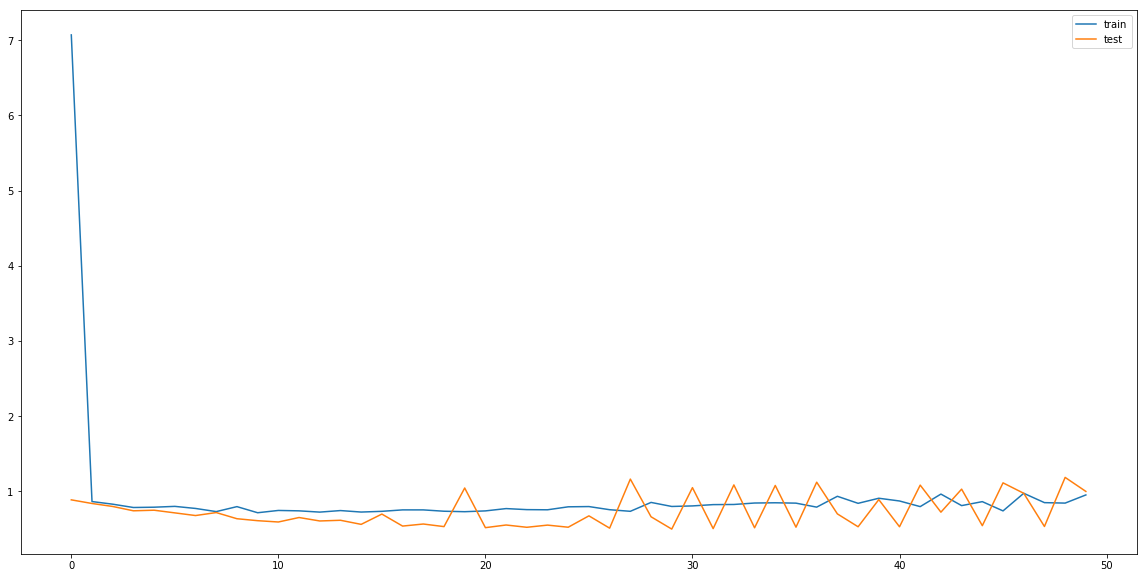

In [18]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
# 滚动预测
pre_list = []

for i in range(276):
    train_X,train_y,test_X,test_y = data_split(values,805+i)

    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1],train_X.shape[2]),
                   activation='relu',return_sequences=False))
    # model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu',kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    # model.add(Dropout(0.5))
    # # model.add(LSTM(16,activation='relu',return_sequences=False))
    # model.add(Dense(16,kernel_initializer='random_uniform',
    #                 bias_initializer='zeros'))
    model.add(Dense(1))
    opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mae',optimizer=opt)

    history = model.fit(train_X, train_y, epochs = 50, batch_size=64, 
                    validation_data=(test_X, test_y),verbose = 0,shuffle=False)
    pre_next = float(model.predict(test_X[0].reshape((1,1,11))))
#     print(pre_next)
    pre_list.append(pre_next)

In [20]:
pre_list[:5]

[13.944812774658203,
 13.082709312438965,
 14.332906723022461,
 13.522396087646484,
 13.289322853088379]

In [21]:
true_list = true_y.tolist()

In [22]:
def restore_log(num_list):
    for i in range(len(num_list)):
        num_list[i] = np.exp(num_list[i])
    return num_list

restore_pre = restore_log(pre_list)
restore_true = restore_log(true_list)

In [23]:
restore_true[:5]

[429709.9999999997,
 942410.0000000014,
 1368180.000000003,
 304540.0000000005,
 302800.00000000064]

In [24]:
true_list[:5]

[429709.9999999997,
 942410.0000000014,
 1368180.000000003,
 304540.0000000005,
 302800.00000000064]

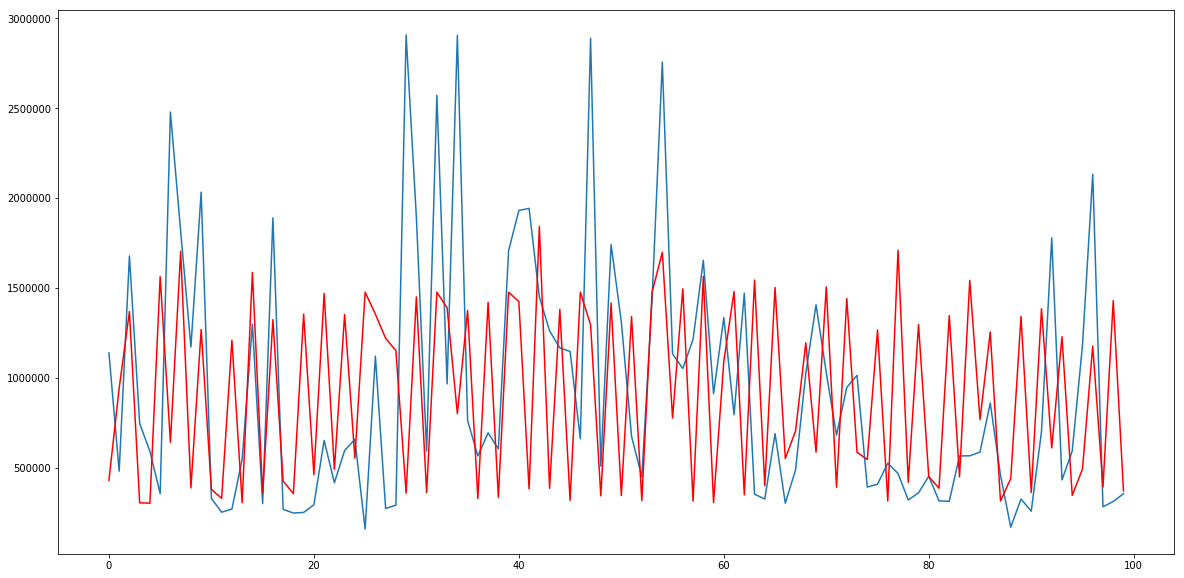

In [25]:
plt.plot(restore_pre[:100])
plt.plot(true_list[:100], color='red')
plt.show()

In [26]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre,restore_true))))
print('误差：%.2f%%'%float((error/len(restore_true))*100))

误差：90.64%


In [27]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(restore_pre)):
    if restore_pre[i] > restore_true[i]:
        count += 1
ratio = count*1.0/len(restore_true)
print("覆盖率为：%.2f%%"% (ratio*100))

覆盖率为：47.46%


In [28]:
# 计算有 多少比例 的数据误差在 20.00% 之内
Percentageratio,per = calc_with_err_per(restore_pre,restore_true,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 16.67% 的数据误差在 20.00% 之内
